In [1]:
!pip install -q torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 409.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 102.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 6.6 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 28.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.5.1.post0 requires torch>=2.1.0, but you have torch 2.0.0+cu118 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 7.2 MB/s eta 0:00:0000:010:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 69.6 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 3.0 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━

In [2]:
# STEP 1: Imports and Configuration

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GATConv
from torchvision.transforms import ToTensor, Resize, Compose
from scipy.spatial import cKDTree

# Configuration
IMG_DIR = "/kaggle/input/er-ihc-images/ER_IHC_Int_Image"
MASK_DIR = "/kaggle/input/er-ihc-mask/Mask_WO_BG"
IMG_SIZE = 256
NUM_CLASSES = 4

COLOR_MAP = {
    (0, 0, 255): 0,           # Blue - Normal
    (0, 255, 0): 1,           # Green - Weak
    (255, 159, 0): 2,         # Orange-Yellow - Moderate
    (0, 216, 255): 3          # Cyanish-Red - Strong
}


def color_to_label(rgb):
    return COLOR_MAP.get(tuple(rgb), -1)


In [3]:
from collections import Counter
import cv2
import os
from glob import glob
import numpy as np



def extract_labels_from_mask(mask_path):
    mask = cv2.imread(mask_path)
    num_labels, labeled = cv2.connectedComponents(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY))
    class_labels = []
    for label in range(1, num_labels):
        component_mask = (labeled == label).astype(np.uint8)
        if component_mask.sum() == 0:
            continue

        # ✅ Get all pixels inside this component and find the most common color
        pixels = mask[component_mask > 0].reshape(-1, 3)
        colors = [tuple(px) for px in pixels]
        if not colors:
            continue
        majority_color = Counter(colors).most_common(1)[0][0]
        label_val = color_to_label(list(majority_color))
        if label_val != -1:
            class_labels.append(label_val)

    return class_labels

# Count over all masks
mask_paths = sorted(glob(os.path.join(MASK_DIR, "*.png")))
total_counter = Counter()

for path in mask_paths:
    labels = extract_labels_from_mask(path)
    total_counter.update(labels)

# Show results
print("✅ Total nuclei count per class across all 220 masks:")
for k in range(4):
    print(f"Class {k} → {total_counter.get(k, 0)} nuclei")


✅ Total nuclei count per class across all 220 masks:
Class 0 → 1523 nuclei
Class 1 → 1343 nuclei
Class 2 → 15004 nuclei
Class 3 → 2779 nuclei


# Feature Extraction and Graph Builder (Node-Level Labels)

In [4]:
def extract_features(img, mask):
    features, labels, positions = [], [], []
    num_labels, labeled = cv2.connectedComponents(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY))

    for label in range(1, num_labels):
        component_mask = (labeled == label).astype(np.uint8)
        coords = np.column_stack(np.where(component_mask > 0))
        if coords.size == 0:
            continue

        # ✅ Use majority color from all pixels in the nucleus
        pixels = mask[component_mask > 0].reshape(-1, 3)
        colors = [tuple(px) for px in pixels]
        if not colors:
            continue
        majority_color = Counter(colors).most_common(1)[0][0]
        label_val = color_to_label(list(majority_color))
        if label_val == -1:
            continue

        cy, cx = coords.mean(axis=0).astype(int)
        roi = img * component_mask[:, :, None]
        vals = roi[component_mask > 0]

        mean_intensity = vals.mean(axis=0)
        area = component_mask.sum()

        features.append(np.concatenate((mean_intensity, [area])))
        labels.append(label_val)
        positions.append([cx, cy])

    return np.array(features), np.array(labels), np.array(positions)


In [5]:
def build_graph_data(features, labels, positions, k=6):
    if len(features) == 0 or len(labels) == 0:
        return None

    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    pos = torch.tensor(positions, dtype=torch.float)

    tree = cKDTree(positions)
    edges = []
    for i, p in enumerate(positions):
        _, neighbors = tree.query(p, k=min(k+1, len(positions)))
        if isinstance(neighbors, int):
            neighbors = [neighbors]
        for j in neighbors[1:]:
            edges.append([i, j])

    if len(edges) == 0:
        return None  # ❗️ No valid edges, skip this graph

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index, y=y, pos=pos)


# GNN Dataset (Node-Level Labels)

In [6]:
from torch_geometric.data import Dataset

class IHCDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        super().__init__()  # 🟢 this is required
        self.img_paths = sorted(glob(os.path.join(img_dir, "*.png")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

    def len(self):  # ✅ NOT __len__ for PyG
        return len(self.img_paths)

    def get(self, idx):  # ✅ REQUIRED for PyG
        max_attempts = self.len()
        attempts = 0
        while attempts < max_attempts:
            img = cv2.imread(self.img_paths[idx])
            mask = cv2.imread(self.mask_paths[idx])
            features, labels, positions = extract_features(img, mask)
            data = build_graph_data(features, labels, positions)
            if data is not None and data.x.size(0) > 0 and data.y.size(0) > 0:
                return data
            idx = (idx + 1) % len(self.img_paths)
            attempts += 1
        raise RuntimeError("No valid graph found after multiple attempts.")


# Node-Level GNN Model

In [7]:
class NodeLevelGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=2, concat=True)
        self.conv2 = GATConv(hidden_channels * 2, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.lin(x)


# Training and Evaluation (Node-Level)

In [8]:
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            probs = F.softmax(out, dim=1).cpu().numpy()
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(data.y.cpu().numpy())
            all_probs.extend(probs)
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def visualize_outputs(y_true, y_pred, y_prob, title_prefix="Node-Level GNN"):
    print(f"\nClassification Report ({title_prefix}):\n", classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(label_binarize(y_true, classes=range(NUM_CLASSES))[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f"Class {i}")
    plt.plot([0, 1], [0, 1], '--')
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(); plt.grid(); plt.show()

    tsne = TSNE(n_components=2)
    embedding = tsne.fit_transform(y_prob)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=y_true, cmap='tab10')
    plt.title(f"{title_prefix} t-SNE")
    plt.colorbar(); plt.show()


#  Run Node-Level GNN

In [9]:
from torch_geometric.loader import DataLoader  # ✅


Training Node-Level GNN:
Epoch 1, Loss: 2.9586
Epoch 2, Loss: 1.1763
Epoch 3, Loss: 0.9274
Epoch 4, Loss: 0.7766
Epoch 5, Loss: 0.7613
Epoch 6, Loss: 0.8798
Epoch 7, Loss: 0.6879
Epoch 8, Loss: 0.7506
Epoch 9, Loss: 0.7042
Epoch 10, Loss: 0.6330
Epoch 11, Loss: 0.5821
Epoch 12, Loss: 0.5144
Epoch 13, Loss: 0.4925
Epoch 14, Loss: 0.4819
Epoch 15, Loss: 0.4920
Epoch 16, Loss: 0.4611
Epoch 17, Loss: 0.4677
Epoch 18, Loss: 0.4760
Epoch 19, Loss: 0.4419
Epoch 20, Loss: 0.4467
Epoch 21, Loss: 0.4563
Epoch 22, Loss: 0.4488
Epoch 23, Loss: 0.4391
Epoch 24, Loss: 0.4250
Epoch 25, Loss: 0.4381
Epoch 26, Loss: 0.4439
Epoch 27, Loss: 0.4450
Epoch 28, Loss: 0.4229
Epoch 29, Loss: 0.4214
Epoch 30, Loss: 0.4309
Epoch 31, Loss: 0.4320
Epoch 32, Loss: 0.4190
Epoch 33, Loss: 0.4279
Epoch 34, Loss: 0.4409
Epoch 35, Loss: 0.4193
Epoch 36, Loss: 0.4189
Epoch 37, Loss: 0.4187
Epoch 38, Loss: 0.4267
Epoch 39, Loss: 0.4226
Epoch 40, Loss: 0.4146
Epoch 41, Loss: 0.4066
Epoch 42, Loss: 0.4128
Epoch 43, Loss: 0

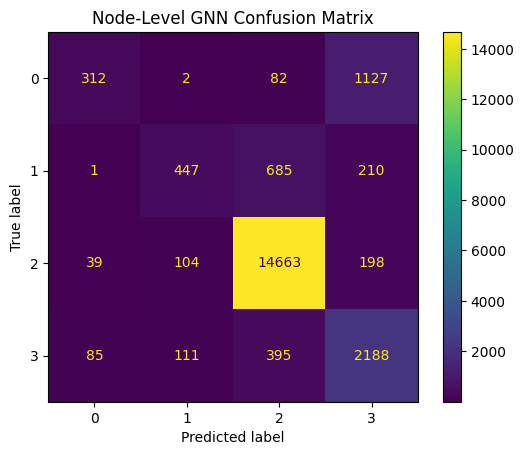

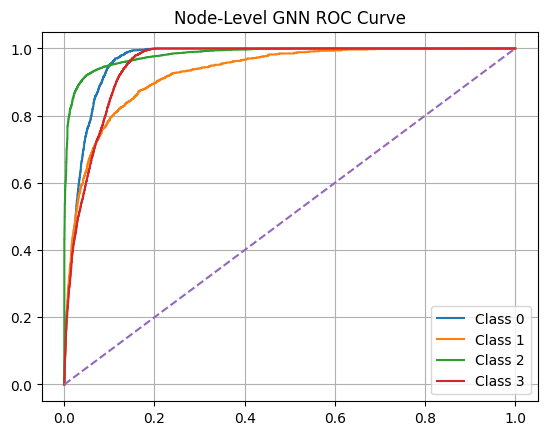

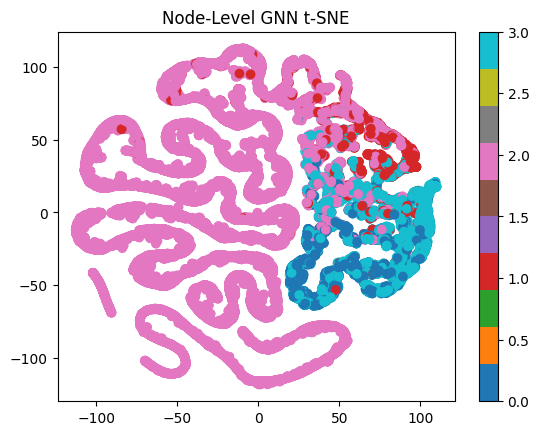

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = IHCDataset(IMG_DIR, MASK_DIR)
loader = DataLoader(dataset, batch_size=1, shuffle=True)  

# Initialize model
model = NodeLevelGNN(in_channels=4, hidden_channels=32, out_channels=NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
print("\nTraining Node-Level GNN:")
for epoch in range(100):
    loss = train(model, loader, optimizer, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Evaluate
print("\nEvaluating Node-Level GNN:")
y_true, y_pred, y_prob = evaluate(model, loader, device)
visualize_outputs(y_true, y_pred, y_prob, title_prefix="Node-Level GNN")
